The purpose of the project is to learn the mapping from polar coordinates to a a discrete 10x10 grid of cells in the plane, using a neural network. 

The supervised dataset is given to you in the form of a generator (to be considered as a black box).

The model must achieve an accuracy of 95%, and it will be evaluated in a way **inversely proportional to the number of its parameters: the smaller, the better.**

**WARNING**: Any solution taking advantage of meta-knowledge about the generator will be automatically rejected.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate
from tensorflow.keras.models import Model

Here is the generator. It returns triples of the form ((theta,rho),out) where (theta,rho) are the polar coordinates of a point in the first quadrant of the plane, and out is a 10x10 map with "1" in the cell corresponding to the point position, and "0" everywhere else.

By setting flat=True, the resulting map is flattened into a vector with a single dimension 100. You can use this variant, if you wish. 

In [2]:
def polar_generator(batchsize,grid=(10,10),noise=.002,flat=False):
  while True:
    x = np.random.rand(batchsize)
    y = np.random.rand(batchsize)
    out = np.zeros((batchsize,grid[0],grid[1]))
    xc = (x*grid[0]).astype(int)
    yc = (y*grid[1]).astype(int)
    for b in range(batchsize):
      out[b,xc[b],yc[b]] = 1
    #compute rho and theta and add some noise
    rho = np.sqrt(x**2+y**2) + np.random.normal(scale=noise)
    theta = np.arctan(y/np.maximum(x,.00001)) + np.random.normal(scale=noise)
    if flat:
      out = np.reshape(out,(batchsize,grid[0]*grid[1]))
    yield ((theta,rho),out)

Let's create an instance of the generator on a grid with dimension 3x4

In [3]:
g1,g2 = 3,4
gen = polar_generator(1,grid=(g1,g2),noise=0.0)

And now let's see a few samples.

In [4]:
(theta,rho),maps = next(gen)
for i,map in enumerate(maps):
  #let us compute the cartesian coordinates
  x = np.cos(theta[i])*rho[i]
  y = np.sin(theta[i])*rho[i]
  print("x coordinate (row): {}".format(int(x*g1)))
  print("y coordinate (col): {}".format(int(y*g2)))
  print("map:")
  print(np.reshape(map,(g1,g2)))

x coordinate (row): 1
y coordinate (col): 3
map:
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


Exercise: add noise to the generator, and check the effect on the "ground truth".

# What to deliver

For the purposes of the project you are supposed to work with the **default 10x10 grid, and the default noise=.002**

The generator must be treatead as a black box, do not tweak it, and do not exploit its semantics that is supposed to be unknown. You are allowed to work with the "flat" modality, if you prefer so.

You need to:
1.   define an accuracy function (take inspiration from the code of the previous cell)
2.   define a neural network taking in input theta and rho, and returning out
3. measure the network's accuracy that must be above 95% (accuracy must be evaluated over at least 20000 samples)
4. tune the network trying to decrease as much as possible the numer of parameters, preserving an accuracy above 95%. Only your best network must be delivered.

You must deliver a SINGLE notebook working on colab, containing the code of the network, its summary, the training history, the code for the accurary metric and its evaluation on the network.

**N.B.** The accuracy must be above 95% but apart from that it does not influence the evaluation. You score will only depend on the number of parameters: the lower, the better.

#Good work!





# Implementation

From this point starts my work.

Dimensions of the matrix output are parameterized

In [5]:
g1,g2 = 10,10

## Accuracy Function

In order to have a good precised accuracy, the evaluation takes 200000 validation samples from the generator, that returns the input (theta and rho) and the correct output tensors. The predicted cartesian coordinates are evaluated appling the NN on input tensors and, for each matrix of the output, and taking row and column positions of the value most similar to 1. Then is counted the correct predictions over the total.  

In [6]:
def accuracy(model):
  gen = polar_generator(200000)
  (theta,rho),maps_true = next(gen)


  maps_pred = model.predict([np.array(theta), np.array(rho)])

  correct_predictions = 0
  total_predictions = len(maps_true)

  for i,map_pred in enumerate(maps_pred):

    (x_pred,y_pred) = np.unravel_index(map_pred.argmax(), map_pred.shape)

    x= np.cos(theta[i])*rho[i]
    y = np.sin(theta[i])*rho[i]
    x_true = int(x*g1)
    y_true = int(y*g2)

    if x_true == x_pred and y_true == y_pred :
      correct_predictions = correct_predictions + 1

  return correct_predictions/total_predictions


## Neural Network



### Definition

In [7]:
input_layer_1 = Input(shape=(1,))
input_layer_2 = Input(shape=(1,))


x = Concatenate(axis=1)([input_layer_1, input_layer_2])

hidden_layers_dims = [5,5]
for i in range(0,len(hidden_layers_dims)):
  x = Dense(hidden_layers_dims[i], activation='relu')(x)

x = Dense(g1*g2, activation='softmax')(x)
output_layer = Reshape((g1,g2))(x)

model = Model([input_layer_1,input_layer_2],output_layer)

### Summary

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 5)            15          ['concatenate[0][0]']        

### Training

The NN takes about 20 minutes to be trained

In [9]:
model.compile(optimizer='adam',loss='mse')

In [10]:
training_samples_number = 4000

history = model.fit(polar_generator(training_samples_number), batch_size=128, steps_per_epoch=1000, epochs=150)


Epoch 1/150
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0095
Epoch 2/150
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0071
Epoch 3/150
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0052
Epoch 4/150
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0042
Epoch 5/150
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0036
Epoch 6/150
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0032
Epoch 7/150
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0030
Epoch 8/150
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0028
Epoch 9/150
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0026
Epoch 10/150
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0025
Epoch 11/150
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0023
Epoch 12/150
1000/1000 [==============================] - 7s 7ms/step - 

### Training History Representation

The chart represent the loss function reduction over the epochs in training

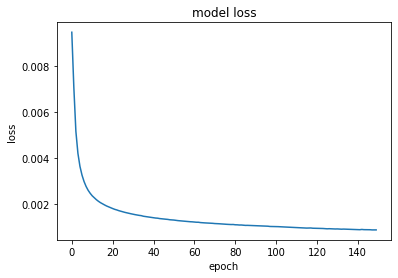

In [11]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Accuracy Evaluation

The accuracy of the model is over 95%

In [12]:
print(accuracy(model))

6250/6250 [==============================] - 5s 788us/step
0.96585
